In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# 데이터셋 로드
(train_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True)

# 이미지 전처리 함수 정의
def preprocess_image(image, label):
    image = tf.image.resize(image, (150, 150))  # 이미지 크기는 150x150
    image /= 255.0                              # 0~1 사이의 값으로 scaling
    return image, label

# 데이터셋 전처리 및 배치 설정, 일괄 적용
BATCH_SIZE = 32
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE)
test_dataset = test_dataset.map(preprocess_image).batch(BATCH_SIZE)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout,Flatten, Dense, Input)

In [ ]:
type(train_dataset), len(train_dataset), type(test_dataset), len(test_dataset)

# train_dataset의 길이 - 582
# 582 * batch_size(32) = 약 18000개
# test_dataset의 길이 - 146
# 146 * batch_size(32) = 약 5000개

(tensorflow.python.data.ops.batch_op._BatchDataset,
 582,
 tensorflow.python.data.ops.batch_op._BatchDataset,
 146)

In [ ]:
for batch_images, batch_labels in train_dataset:
  print("Batch Images Shape:", batch_images.shape)
  print("Batch Labels Shape:", batch_labels.shape)
  break

Batch Images Shape: (32, 150, 150, 3)
Batch Labels Shape: (32,)


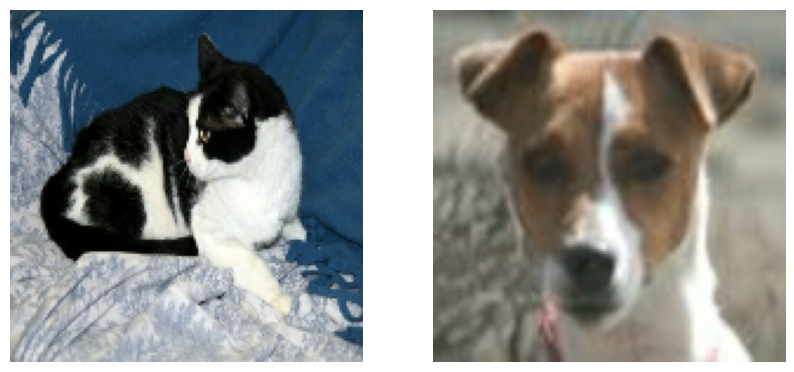

In [ ]:
first_batch_images, first_batch_labels = next(iter(train_dataset.take(1)))
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(first_batch_images[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(first_batch_images[1])
plt.axis('off')

plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# 사전 훈련된 ResNet50 모델 로드 (맨 위 레이어 제외)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# 사전 훈련된 모델의 레이어를 동결
for layer in base_model.layers:
  layer.trainable = False

# 새로운 모델 생성 (사전 훈련된 모델 위에)
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               26214912  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 49803137 (189.98 MB)
Trainable params: 26215425 (100.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50
582/582 [==============================] - 54s 81ms/step - loss: 0.7582 - acc: 0.5515 - val_loss: 0.6795 - val_acc: 0.5957
Epoch 2/50
582/582 [==============================] - 50s 83ms/step - loss: 0.6782 - acc: 0.5652 - val_loss: 0.6563 - val_acc: 0.6438
Epoch 3/50
582/582 [==============================] - 47s 79ms/step - loss: 0.6698 - acc: 0.5801 - val_loss: 0.6466 - val_acc: 0.6728
Epoch 4/50
582/582 [==============================] - 47s 80ms/step - loss: 0.6620 - acc: 0.5946 - val_loss: 0.6531 - val_acc: 0.6320
Epoch 5/50
582/582 [==============================] - 49s 82ms/step - loss: 0.6540 - acc: 0.6087 - val_loss: 0.6324 - val_acc: 0.6814
Epoch 6/50
582/582 [==============================] - 50s 83ms/step - loss: 0.6437 - acc: 0.6271 - val_loss: 0.6040 - val_acc: 0.6967
Epoch 7/50
582/582 [==============================] - 48s 80ms/step - loss: 0.6496 - acc: 0.6116 - val_loss: 0.6445 - val_acc: 0.6488
Epoch 8/50
582/582 [==============================] - 50s 84ms

KeyboardInterrupt: ignored

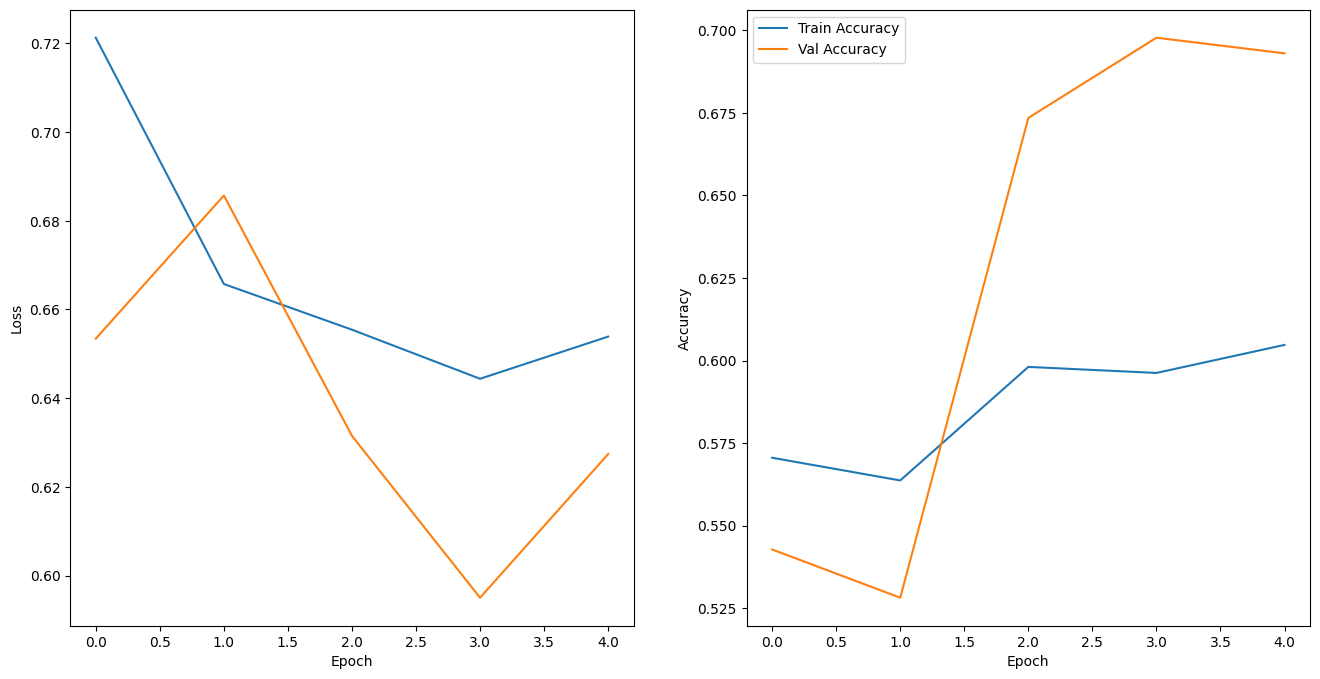

In [ ]:
# 학습곡선 그리기
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch

  plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],label='Val Loss')

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'],hist['acc'],label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'],label='Val Accuracy')
  plt.legend()

  plt.show()

plot_history(history)

In [ ]:
# 테스트 정확도 평가
test_loss, test_acc = model.evaluate(test_dataset)
print('테스트 정확도:', test_acc)

146/146 [==============================] - 9s 58ms/step - loss: 0.6274 - acc: 0.6930
테스트 정확도: 0.6930352449417114
